# ColumbiaX-02-Bayesian-Classifier

## Set Up Session

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

## Data Generation

In [2]:
# Config:
K = 5

In [3]:
# Class prior--Dirichlet distribution:
prior = np.random.dirichlet(np.ones(K))

In [4]:
# Sample generation--mus:
mu = np.asarray(
    [
        [4.5*np.cos(i*2*np.pi/K), 5.0*np.sin(i*2*np.pi/K)] for i in xrange(K)
    ]
)

In [5]:
# Sample generation--cov mats:
cov = np.asarray(
    [
        np.matmul(x.T, x) for x in (1.0*np.random.randn(2, 2) for _ in xrange(K))
    ]
)

In [6]:
# Number of samples:
N = 10000

In [7]:
# Generate sample classes:
classes = np.random.multinomial(N, prior)

In [8]:
# Generate sample features:
X = np.concatenate(
    tuple(
        np.random.multivariate_normal(mean=mu[i], cov=cov[i], size = classes[i]) for i in xrange(K)
    )
)
y = np.concatenate(
    tuple(
        i*np.ones(classes[i]) for i in xrange(K)
    )
).astype(np.int)

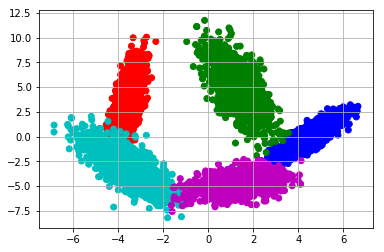

In [9]:
# Visualize:
import matplotlib.pyplot as plt
# Scatter plot:
plt.scatter(
    X[:, 0], X[:, 1], 
    color = np.asarray(
        ['b', 'g', 'r', 'c', 'm', 'y']
    )[y]
)
plt.grid()
plt.show()

In [10]:
# Split train-test dataset:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

In [11]:
# Save data for command-line application:
import pandas as pd

pd.DataFrame(data = X_train).to_csv('X_train.csv', index=False, header=False)
pd.DataFrame(data = y_train).to_csv('y_train.csv', index=False, header=False)
pd.DataFrame(data = X_test).to_csv('X_test.csv', index=False, header=False)

## Maximum-Likelihood Estimation for Priors & Generative Parameters

In [12]:
# Class priors:
prior_ml = np.bincount(y_train).astype(np.float) / y_train.shape[0]

In [13]:
# Gaussian parameters:
class_indices = np.unique(y_train)

mu_ml = np.asarray(
    [np.mean(X_train[y_train == class_idx], axis = 0) for class_idx in class_indices]
)

cov_ml = np.asarray(
    [np.cov(X_train[y_train == class_idx].T, bias=True) for class_idx in class_indices]
)

In [14]:
# Posterior probabilities for test cases:
pdfs = [multivariate_normal(mean=mu_ml[class_idx], cov=cov_ml[class_idx]) for class_idx in class_indices]
posteriors = np.column_stack(
    tuple(
        prior_ml[class_idx]*pdfs[class_idx].pdf(X_test) for class_idx in class_indices
    )
) 
posteriors = np.matmul(
    np.diag(1.0 / posteriors.sum(axis=1)),
    posteriors
)

In [15]:
# Predict using Bayesian classifier:
y_pred = np.argmax(posteriors, axis = 1)

In [16]:
print "[Prediction Accuracy]: {:.2f}%".format(100.0*np.mean(y_pred == y_test))

[Prediction Accuracy]: 98.30%


## Generate Output

In [17]:
# Posterior probabilities for test instances:
with open("probs_test.csv", "w") as posteriors_output:
    posteriors_output.write(
        "\n".join(
            ",".join(str(val) for val in vals) for vals in posteriors
        )
    )